In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
import sklearn.pipeline as ppln
import sklearn.preprocessing as prep
import sklearn.svm as svm
import sklearn.metrics as metrics
import seaborn as sns
import sklearn.neighbors as neigb
from sklearn import tree
import pandas as pd
import sklearn.naive_bayes as nbayes
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from imblearn.over_sampling import SMOTE

## Reading the data and preprocessing

In [2]:
#loading the data from the csv file
weather = pd.read_csv('weather.csv')

#dropping irrelevant features
weather = weather.drop('formatted_date', axis = 1)
weather = weather.drop('loud_cover', axis = 1)

In [3]:
# checking the values for summary, daily_summary and precipitation type
print(weather['precip'].value_counts())
print("\n-----------------\n")
print(weather['summary'].value_counts())
print("\n-----------------\n")
print(weather['daily_summary'].value_counts())

# daily_summary and summary has too many possible values, so we remove it
weather = weather.drop('daily_summary', axis = 1)
weather = weather.drop('summary', axis = 1)

precip
rain    85224
snow    10712
none      517
Name: count, dtype: int64

-----------------

summary
Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Windy and Mostly Cloudy                   35
Breezy and Foggy                          35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     

In [4]:
#mapping categorical variables to numerical
weather_mapping = {'none': 0, 'snow': 1, 'rain': 2}
weather['precip'] = weather['precip'].map(weather_mapping)
print(weather.head())

   precip       temp  apparent_temp  humidity  wind_speed  wind_bearing  \
0       0  19.016667      19.016667      0.81     14.8764           163   
1       0  17.850000      17.850000      0.81     13.7977           169   
2       0  16.322222      16.322222      0.81     10.8192           151   
3       0  12.566667      12.566667      0.81      9.0160           159   
4       0  12.927778      12.927778      0.81     17.6295           197   

   visibility  air_pressure  
0       9.982       1002.40  
1       9.982       1001.79  
2       9.982       1001.60  
3       9.982       1001.92  
4      16.100       1002.20  


In [5]:
#splitting the dataset into target variable and features
X = weather.drop('precip', axis=1)
y = weather['precip']

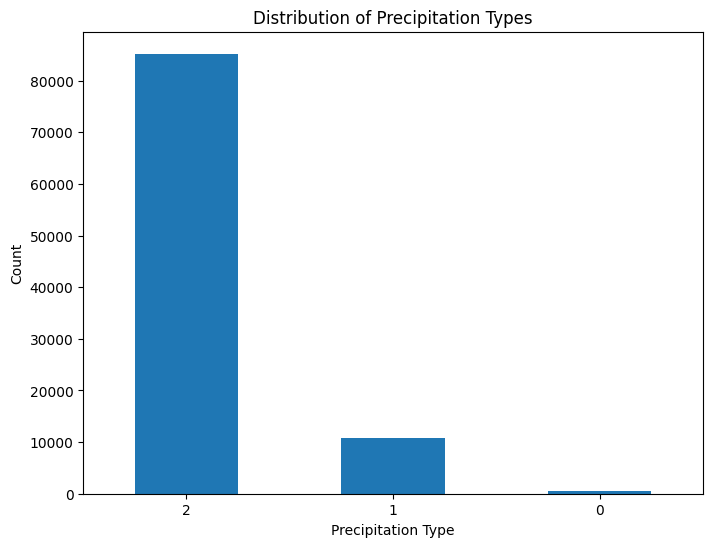

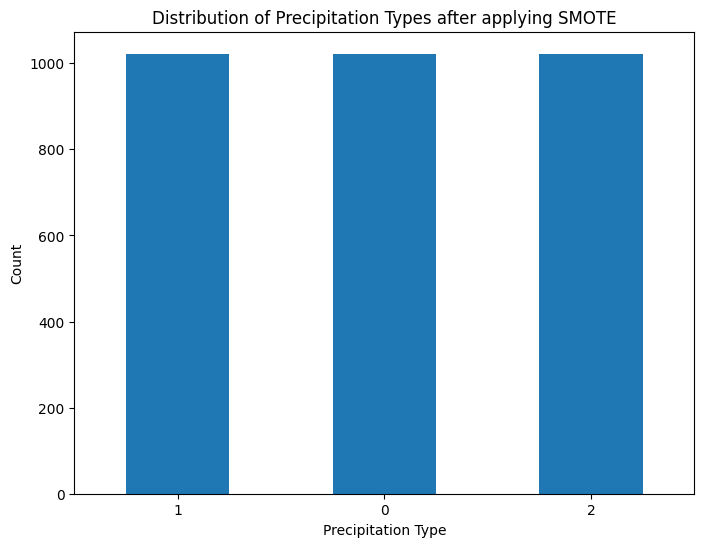

In [6]:
from imblearn.over_sampling import SMOTE


# Plotting the origianl distribution of the precip variable
precipitation_counts = weather['precip'].value_counts()
plt.figure(figsize=(8, 6))
precipitation_counts.plot(kind='bar')
plt.title('Distribution of Precipitation Types')
plt.xlabel('Precipitation Type')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

#stratified sampling
# sample_num = 3500
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= sample_num, stratify=y, random_state=42)

#sampling using SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
desired_fraction = 0.015

X_train, _, y_train, _ = train_test_split(
    X_train_resampled, y_train_resampled, 
    train_size=desired_fraction, 
    stratify=y_train_resampled, 
    random_state=42
)

plt.figure(figsize=(8, 6))
y_train.value_counts().plot(kind='bar')
plt.title('Distribution of Precipitation Types after applying SMOTE')
plt.xlabel('Precipitation Type')
plt.ylabel('Count')
plt.xticks(rotation=0) 
plt.show()

## Method 1: Decision tree classifier

### Finding the optimal tree depth with 10-fold cross-validation

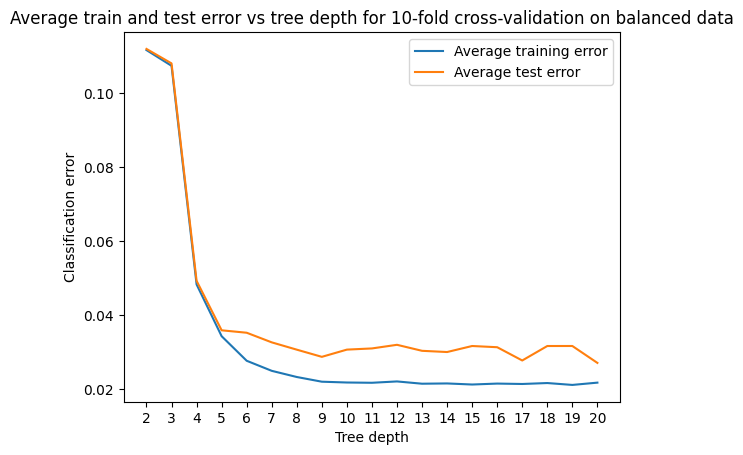

In [7]:
train_errors = []
test_errors = []
tree_depth = range(2,21)
stratified_kfold = StratifiedKFold(n_splits = 10, shuffle = True)

for depth in tree_depth:
    kfold_train_errors = []
    kfold_test_errors = []

    for train_index, test_index in stratified_kfold.split(X_train, y_train):
        X_train_kfold, X_test_kfold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_kfold, y_test_kfold = y_train.iloc[train_index], y_train.iloc[test_index]
        
        kfold_dtc = DecisionTreeClassifier(criterion = "gini", min_samples_split=100, max_depth=depth)
        kfold_dtc.fit(X_train_kfold, y_train_kfold)
        
        y_train_predict_kfold = kfold_dtc.predict(X_train_kfold)
        y_test_predict_kfold = kfold_dtc.predict(X_test_kfold)
        
        train_error = 1 - accuracy_score(y_train_kfold, y_train_predict_kfold)
        test_error = 1 - accuracy_score(y_test_kfold, y_test_predict_kfold)
        
        kfold_train_errors.append(train_error)
        kfold_test_errors.append(test_error)
        
    avg_train_error = np.mean(kfold_train_errors)
    avg_test_error = np.mean(kfold_test_errors)
    
    train_errors.append(avg_train_error)
    test_errors.append(avg_test_error)
plt.plot(tree_depth, train_errors, label = "Average training error")
plt.plot(tree_depth, test_errors, label = "Average test error")
plt.xlabel("Tree depth")
plt.ylabel("Classification error")
plt.xticks(tree_depth)
plt.legend()
plt.title("Average train and test error vs tree depth for 10-fold cross-validation on balanced data")
plt.show()



The optimal tree depth seems to be 6.

### Building the decision tree classifier model

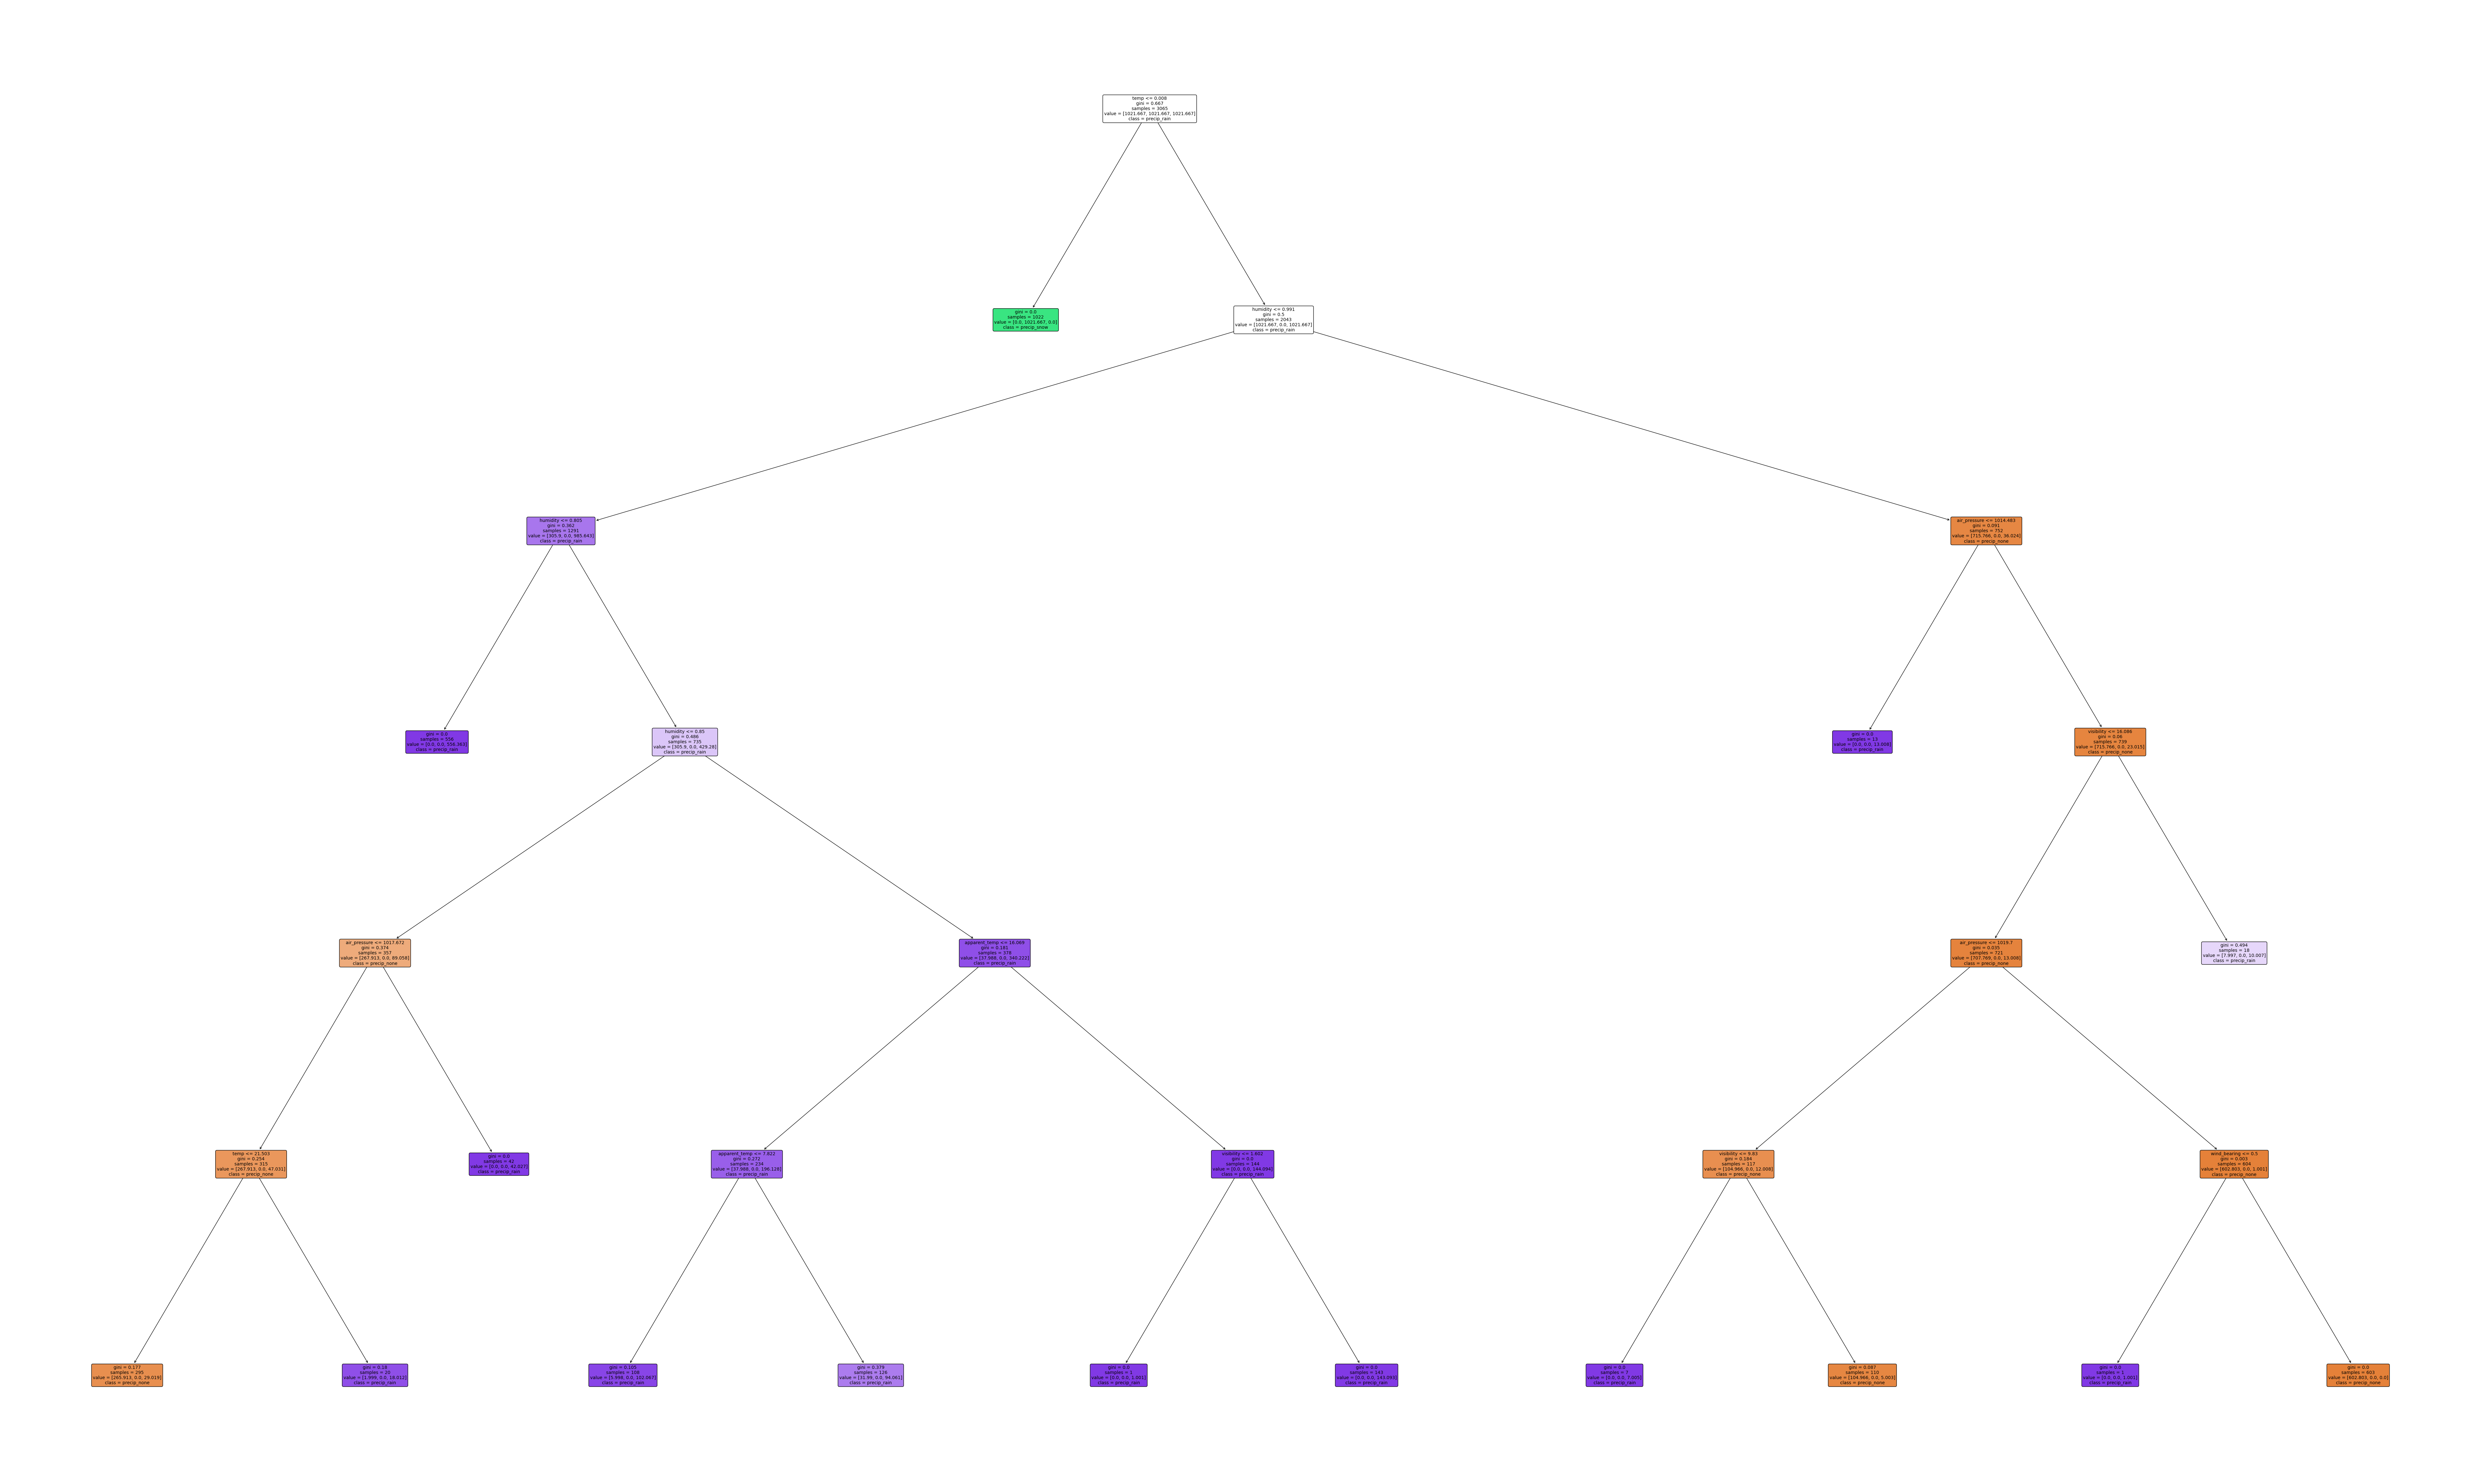

In [8]:
attribute_names = X.columns.tolist()
class_names = ['precip_none', 'precip_snow', 'precip_rain']
depth = 6
dtc = DecisionTreeClassifier(criterion = "gini", min_samples_split=100, max_depth = depth, class_weight='balanced')
dtc.fit(X_train, y_train)

plt.figure(figsize = (100, 60))
plot_tree(dtc, feature_names = attribute_names, class_names =class_names, filled = True, rounded = True, fontsize=10)

plt.show()

### Measuring the accuracy

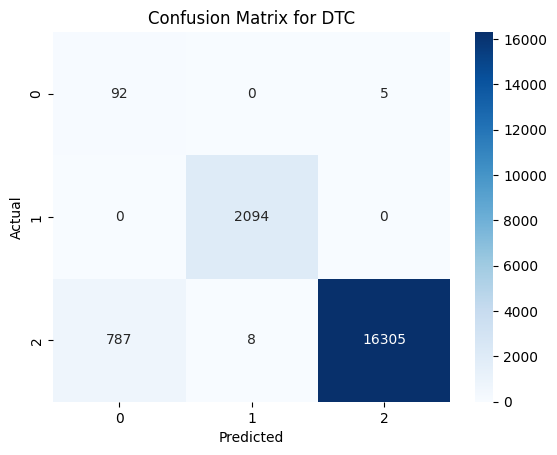



              precision    recall  f1-score   support

           0       0.10      0.95      0.19        97
           1       1.00      1.00      1.00      2094
           2       1.00      0.95      0.98     17100

    accuracy                           0.96     19291
   macro avg       0.70      0.97      0.72     19291
weighted avg       0.99      0.96      0.97     19291



In [9]:
y_pred = dtc.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for DTC')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\n")
print(classification_report(y_test, y_pred))

## Method 2: K-Nearest Neighbours Classifier

### Choosing the optimal number of neighbours and distance metric with Leave-One-Out Cross-Validation

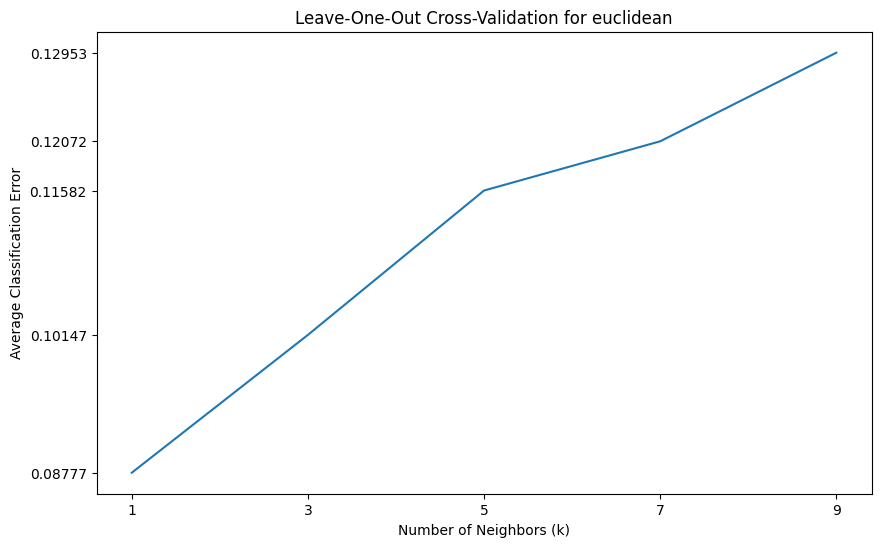

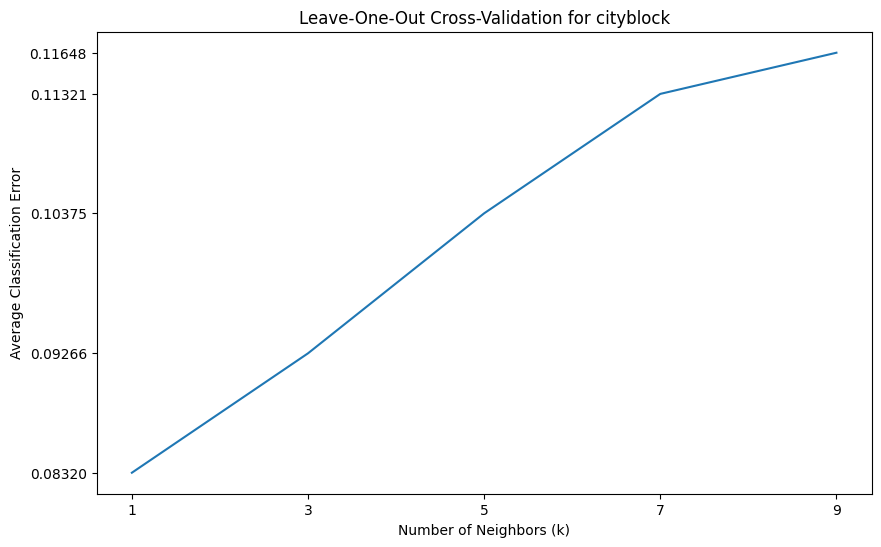

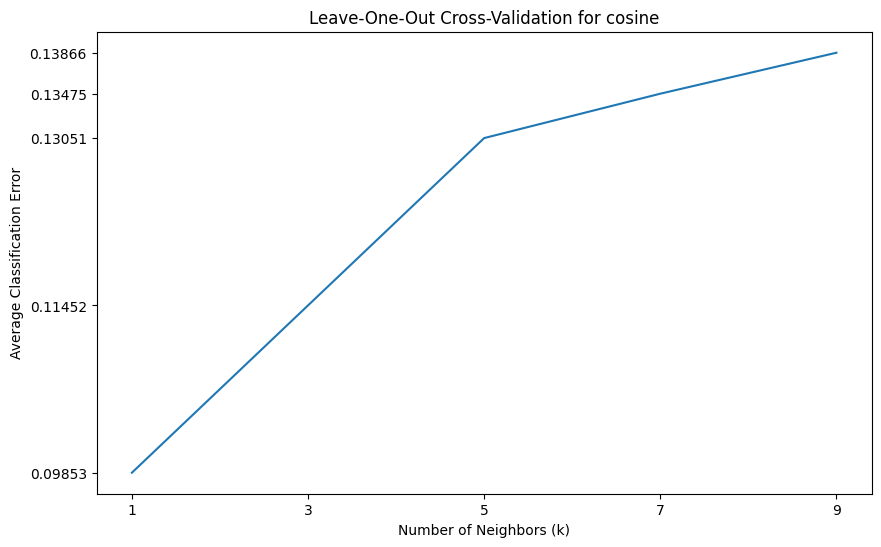

In [10]:
k_values = np.arange(1, 10, 2)
mean_errors = np.zeros(len(k_values))

for metric in ['euclidean', 'cityblock', 'cosine']:
    for i, k in enumerate(k_values):
        knn = KNeighborsClassifier(n_neighbors=k, metric = metric)
        loo = LeaveOneOut()
        scores = cross_val_score(knn, X_train, y_train, cv= loo, scoring = 'accuracy')
        mean_errors[i] = 1 - np.mean(scores)
    
    plt.figure(figsize=(10,6))
    plt.plot(k_values, mean_errors)
    plt.title(f'Leave-One-Out Cross-Validation for {metric}')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Average Classification Error')
    plt.xticks(k_values)
    plt.yticks(mean_errors)
    plt.show()

Cityblock yields the lowest classification error with 1 neighbour, so it will be used it to build the model.

### Performing KNN Classification

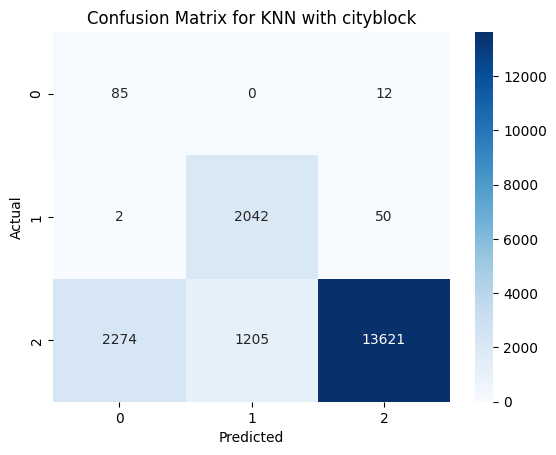

              precision    recall  f1-score   support

           0       0.04      0.88      0.07        97
           1       0.63      0.98      0.76      2094
           2       1.00      0.80      0.88     17100

    accuracy                           0.82     19291
   macro avg       0.55      0.88      0.57     19291
weighted avg       0.95      0.82      0.87     19291



In [11]:
# #knn for cosine
# knn = KNeighborsClassifier(n_neighbors = 1, metric = 'cosine')
# knn.fit(X_train, y_train)
# y_pred = knn.predict(X_test)

# sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix for KNN with cosine')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

# print(classification_report(y_test, y_pred, zero_division = 1))

# #knn for euclidean
# knn = KNeighborsClassifier(n_neighbors = 1, metric = 'euclidean')
# knn.fit(X_train, y_train)
# y_pred = knn.predict(X_test)

# sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix for KNN with euclidean')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

# print(classification_report(y_test, y_pred, zero_division = 1))

#knn for cityblock - optimal
knn = KNeighborsClassifier(n_neighbors = 1, metric = 'cityblock')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for KNN with cityblock')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_test, y_pred, zero_division = 1))
